In [15]:
%load_ext autoreload
%autoreload 2
from pathlib import Path
from skimage.io import imread
import matplotlib.pyplot as plt
import pigleg_cv
import shutil

2024-07-16 12:09:50.093 | DEBUG    | incision_detection_mmdet:<module>:19 - 1.12.0a0+8a1a93a
2024-07-16 12:09:50.094 | DEBUG    | incision_detection_mmdet:<module>:24 - mmdet.version=2.25.0
2024-07-16 12:09:50.095 | DEBUG    | incision_detection_mmdet:<module>:29 - 11.7
2024-07-16 12:09:50.096 | DEBUG    | incision_detection_mmdet:<module>:30 - GCC 9.4
2024-07-16 12:09:50.237 | DEBUG    | pigleg_cv:<module>:60 - DEVICE=cuda:0


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [16]:
!pwd

/webapps/piglegsurgery/piglegcv


In [17]:
import torch

torch.cuda.is_available()

True

In [18]:
!nvidia-smi

Tue Jul 16 12:09:50 2024       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 555.42.02              Driver Version: 555.42.02      CUDA Version: 12.5     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce RTX 4060 Ti     Off |   00000000:0B:00.0 Off |                  N/A |
|  0%   60C    P8             17W /  165W |      18MiB /  16380MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [19]:
torch.__version__

'1.12.0a0+8a1a93a'

In [20]:
Path("~/.cache/torch/hub/checkpoints/").expanduser().exists()

False

In [21]:
!ls ~/.cache/torch/hub/checkpoints/

ls: cannot access '/home/appuser/.cache/torch/hub/checkpoints/': No such file or directory


In [22]:
# pip install mmcv-full

In [23]:
import logging
import mmcv

# logger = logging.getLogger(name='torch')
# logger.setLevel(logging.WARNING)

# print(logging.root.manager.loggerDict)

# loggers = [logging.getLogger(name=name).setLevel(logging.WARNING) for name in logging.root.manager.loggerDict]
# loggers



In [24]:
loggers = [logging.getLogger(name=name) for name in logging.root.manager.loggerDict]

In [25]:
loggers

[<Logger concurrent.futures (WARNING)>,
 <Logger concurrent (WARNING)>,
 <Logger asyncio (WARNING)>,
 <Logger tornado.access (WARNING)>,
 <Logger tornado (WARNING)>,
 <Logger tornado.application (WARNING)>,
 <Logger tornado.general (WARNING)>,
 <Logger prompt_toolkit.buffer (WARNING)>,
 <Logger prompt_toolkit (WARNING)>,
 <Logger parso.python.diff (WARNING)>,
 <Logger parso.python (WARNING)>,
 <Logger parso (WARNING)>,
 <Logger parso.cache (WARNING)>,
 <Logger pkg_resources.extern.packaging.tags (WARNING)>,
 <Logger pkg_resources.extern.packaging (WARNING)>,
 <Logger pkg_resources.extern (WARNING)>,
 <Logger pkg_resources (WARNING)>,
 <Logger IPKernelApp (DEBUG)>,
 <Logger urllib3.util.retry (WARNING)>,
 <Logger urllib3.util (WARNING)>,
 <Logger urllib3 (WARNING)>,
 <Logger urllib3.connection (WARNING)>,
 <Logger urllib3.response (WARNING)>,
 <Logger urllib3.connectionpool (WARNING)>,
 <Logger urllib3.poolmanager (WARNING)>,
 <Logger charset_normalizer (WARNING)>,
 <Logger socks (WARNI

In [26]:
from loguru import logger

# Run whole video processing

In [27]:
is_microsurgery = False
test_first_seconds = False
use_application_outputdir = False
force_tracker = False

patch = "*/Anasto*.mp4"
# patch = "*/2023_10_11_B-Grübbel_Mareike_Fortlaufende_Transkutannaht.mov"
patch = "Einzel.MOV"
patch = "test_4.mp4"; n_stitches=0
patch = "2021_11_03_A_Tengler"
# patch = "Sascha.mp4"; n_stitches=5
# patch = "micro_01*.mp4"
# patch = "2023_10_11_B_Seltmann_Charlotte_fortlaufende_Transcutannaht.mp4"; n_stitches=5
# patch = "Katharina_Einzelknopfnaht"; n_stitches=3
# patch = "Johanna"
# n_stitches = 2

img_pths = list(Path("../piglegsurgeryweb/media/upload/").glob(f"*/*{patch}*"))
mediafile_path = img_pths[0]


# original outputdir
if use_application_outputdir:
    outputdir = list(list(Path("../piglegsurgeryweb/media/").glob(f"*/*{patch}*.zip"))[0].parent.glob("*/meta.json"))[0].parent
    outputdir = outputdir.absolute().resolve()
    outputdir
else:
    outputdir = Path("./del_test_video_output/") / mediafile_path.name

In [28]:
mediafile_path

PosixPath('../piglegsurgeryweb/media/upload/20220707-184836_medium-2021_11_03_A_Tengler_Sophie_Einzelknopfnaht_Schweinefu__91a393b6f2a60572b441ad91cb5cc64e40ed2b65/medium-2021_11_03_A_Tengler_Sophie_Einzelknopfnaht_Schweinefu_.mp4')

In [29]:
# list(zf.parent.glob("*"))

## Do whole processing together


2024-07-16 12:09:51.538 | DEBUG    | pigleg_cv:__init__:109 - ###############
2024-07-16 12:09:51.539 | DEBUG    | pigleg_cv:__init__:110 - device=cuda
2024-07-16 12:09:51.540 | DEBUG    | pigleg_cv:__init__:111 - test_first_seconds=False
2024-07-16 12:09:51.541 | DEBUG    | pigleg_cv:__init__:112 - is_microsurgery=False
2024-07-16 12:09:51.542 | DEBUG    | pigleg_cv:__init__:143 - self.is_microsurgery=False
2024-07-16 12:09:51.542 | INFO     | pigleg_cv:run:147 - CV processing started on ../piglegsurgeryweb/media/upload/20220707-184836_medium-2021_11_03_A_Tengler_Sophie_Einzelknopfnaht_Schweinefu__91a393b6f2a60572b441ad91cb5cc64e40ed2b65/medium-2021_11_03_A_Tengler_Sophie_Einzelknopfnaht_Schweinefu_.mp4, outputdir=del_test_video_output/medium-2021_11_03_A_Tengler_Sophie_Einzelknopfnaht_Schweinefu_.mp4
2024-07-16 12:09:51.543 | DEBUG    | pigleg_cv:run:150 - self.is_microsurgery=False
2024-07-16 12:09:51.544 | DEBUG    | pigleg_cv:run:151 - False, <class 'bool'>
2024-07-16 12:09:51.545

Fusing layers... 
IDetect.fuse
load checkpoint from local path: /webapps/piglegsurgery/piglegcv/resources/incision_detection_models/220326_234659_mmdet.pth


2024-07-16 12:09:56.271 | DEBUG    | incision_detection_mmdet:save_incision_cropped_images:292 - number of detected incisions = 1
2024-07-16 12:09:56.274 | DEBUG    | pigleg_cv:get_parameters_for_crop_rotate_rescale:509 - qr_data={'is_microsurgery': False, 'pix_size_method': 'weighted_average', 'is_detected': False, 'box': [], 'pix_size': 0.00020818262723837596, 'incision_bboxes': [[846.2235717773438, 698.3814086914062, 1123.12890625, 783.2678833007812, 0.9816725850105286]], 'qr_size': 0.027, 'size_by_scene': 0.00015625, 'text': None, 'pix_size_single_frame_detector_m': None, 'bbox_scene_area': [136.36756896972656, 2.5737996101379395, 1781.1903076171875, 978.572509765625, 0.6198498606681824], 'bbox_micro_calibration': [], 'qr_scissors_frame_detected': False, 'qr_bboxes_SID': [], 'scene_width_m': 0.3997106442976818, 'pix_sizes': array([ 0.00021668,  0.00019782,  0.00021833,  0.00020834,  0.00020508,  0.00015625]), 'pix_sizes_weights': [0.9816725850105286, 0.999624490737915, 0.9991599321

Fusing layers... 
IDetect.fuse


2024-07-16 12:10:01.578 | DEBUG    | run_qr:get_bboxes:51 - saving single_image_detector result
2024-07-16 12:10:01.650 | DEBUG    | run_qr:interpret_bboxes:138 - bboxes[3]=array([[     177.25,      261.82,      565.92,      422.09,     0.14236],
       [     91.065,      33.192,      628.76,      417.11,    0.080178]], dtype=float32)
2024-07-16 12:10:01.651 | DEBUG    | tools:sort_bboxes_and_masks_by_confidence:259 - sorted_indices=array([0, 1]), int64
2024-07-16 12:10:01.652 | DEBUG    | run_qr:_holes_pix_sizes:90 - pix_sizes_holes=array([ 0.00044946,  0.00043807,  0.00045332,  0.00042104], dtype=float32)
2024-07-16 12:10:01.653 | DEBUG    | run_qr:_holes_pix_sizes:91 - pix_sizes_weights=array([    0.99928,     0.99839,     0.99816,     0.99354], dtype=float32)
2024-07-16 12:10:01.839 | DEBUG    | run_qr:bbox_info_extraction_from_frame:341 - qr_data={'is_microsurgery': False, 'pix_size_method': 'weighted_average', 'is_detected': False, 'box': [], 'pix_size': 0.0004528529601282334, 'i

Fusing layers... 
IDetect.fuse


2024-07-16 12:10:02.010 | DEBUG    | run_qr:interpret_bboxes:138 - bboxes[3]=array([[     177.25,      261.82,      565.92,      422.09,     0.14236],
       [     91.065,      33.192,      628.76,      417.11,    0.080178]], dtype=float32)
2024-07-16 12:10:02.011 | DEBUG    | tools:sort_bboxes_and_masks_by_confidence:259 - sorted_indices=array([0, 1]), int64
2024-07-16 12:10:02.012 | DEBUG    | run_qr:_holes_pix_sizes:90 - pix_sizes_holes=array([ 0.00044946,  0.00043807,  0.00045332,  0.00042104], dtype=float32)
2024-07-16 12:10:02.013 | DEBUG    | run_qr:_holes_pix_sizes:91 - pix_sizes_weights=array([    0.99928,     0.99839,     0.99816,     0.99354], dtype=float32)
2024-07-16 12:10:02.197 | DEBUG    | run_qr:bbox_info_extraction_from_frame:341 - qr_data={'is_microsurgery': False, 'pix_size_method': 'weighted_average', 'is_detected': False, 'box': [], 'pix_size': 0.0004528529601282334, 'incision_bboxes': [[311.5303649902344, 309.2019958496094, 429.6953125, 337.8912048339844, 0.96351

Fusing layers... 
IDetect.fuse
load checkpoint from local path: /webapps/piglegsurgery/piglegcv/resources/incision_detection_models/220326_234659_mmdet.pth


/home/appuser/mmdetection/mmdet/datasets/utils.py:66: UserWarning: "ImageToTensor" pipeline is replaced by "DefaultFormatBundle" for batch inference. It is recommended to manually replace it in the test data pipeline in your config file.
  warnings.warn(
2024-07-16 12:10:03.091 | DEBUG    | incision_detection_mmdet:save_incision_cropped_images:292 - number of detected incisions = 1
2024-07-16 12:10:03.094 | DEBUG    | incision_detection_mmdet:save_incision_cropped_images:292 - number of detected incisions = 1
2024-07-16 12:10:03.095 | DEBUG    | run_perpendicular:main_perpendicular:345 - len(imgs)=1
2024-07-16 12:10:03.143 | DEBUG    | tools:save_json:17 - Writing 'del_test_video_output/medium-2021_11_03_A_Tengler_Sophie_Einzelknopfnaht_Schweinefu_.mp4/perpendicular_0.json'
2024-07-16 12:10:03.146 | DEBUG    | tools:save_json:28 - updated keys: ['intersections', 'alphas']
2024-07-16 12:10:03.680 | DEBUG    | stitch_detection_mmdet:run_stitch_detection:54 - cfg_path=PosixPath('stitch_de

load checkpoint from local path: /webapps/piglegsurgery/piglegcv/resources/stitch_detection_models/model.pth


/home/appuser/mmdetection/mmdet/datasets/utils.py:66: UserWarning: "ImageToTensor" pipeline is replaced by "DefaultFormatBundle" for batch inference. It is recommended to manually replace it in the test data pipeline in your config file.
  warnings.warn(
2024-07-16 12:10:04.455 | DEBUG    | tools:save_json:17 - Writing 'del_test_video_output/medium-2021_11_03_A_Tengler_Sophie_Einzelknopfnaht_Schweinefu_.mp4/stitch_detection_0.json'
2024-07-16 12:10:04.456 | DEBUG    | tools:save_json:28 - updated keys: ['stitch_labels', 'stitch_bboxes']
2024-07-16 12:10:04.458 | DEBUG    | stitch_detection_mmdet:run_stitch_detection:115 - number of filtered stitches = 4
2024-07-16 12:10:04.458 | DEBUG    | stitch_detection_mmdet:run_stitch_detection:116 - Stitch detection finished, boxes in: del_test_video_output/medium-2021_11_03_A_Tengler_Sophie_Einzelknopfnaht_Schweinefu_.mp4/stitch_detection_0.json
2024-07-16 12:10:04.526 | DEBUG    | stitch_detection_mmdet:run_stitch_analyser:194 - R-squared upper

load checkpoint from local path: /webapps/piglegsurgery/piglegcv/resources/tracker_model_bytetrack/epoch.pth
The model and loaded state dict do not match exactly

unexpected key in source state_dict: ema_detector_backbone_stem_conv_conv_weight, ema_detector_backbone_stem_conv_bn_weight, ema_detector_backbone_stem_conv_bn_bias, ema_detector_backbone_stem_conv_bn_running_mean, ema_detector_backbone_stem_conv_bn_running_var, ema_detector_backbone_stem_conv_bn_num_batches_tracked, ema_detector_backbone_stage1_0_conv_weight, ema_detector_backbone_stage1_0_bn_weight, ema_detector_backbone_stage1_0_bn_bias, ema_detector_backbone_stage1_0_bn_running_mean, ema_detector_backbone_stage1_0_bn_running_var, ema_detector_backbone_stage1_0_bn_num_batches_tracked, ema_detector_backbone_stage1_1_main_conv_conv_weight, ema_detector_backbone_stage1_1_main_conv_bn_weight, ema_detector_backbone_stage1_1_main_conv_bn_bias, ema_detector_backbone_stage1_1_main_conv_bn_running_mean, ema_detector_backbone_stage1

2024-07-16 12:10:09,842 - mmtrack - INFO - initialize CSPDarknet with init_cfg {'type': 'Kaiming', 'layer': 'Conv2d', 'a': 2.23606797749979, 'distribution': 'uniform', 'mode': 'fan_in', 'nonlinearity': 'leaky_relu'}
2024-07-16 12:10:10,034 - mmtrack - INFO - initialize YOLOXPAFPN with init_cfg {'type': 'Kaiming', 'layer': 'Conv2d', 'a': 2.23606797749979, 'distribution': 'uniform', 'mode': 'fan_in', 'nonlinearity': 'leaky_relu'}
2024-07-16 12:10:10,177 - mmtrack - INFO - initialize YOLOXHead with init_cfg {'type': 'Kaiming', 'layer': 'Conv2d', 'a': 2.23606797749979, 'distribution': 'uniform', 'mode': 'fan_in', 'nonlinearity': 'leaky_relu'}


load checkpoint from local path: /webapps/piglegsurgery/piglegcv/resources/tracker_model_bytetrack_hands_tools/epoch.pth


2024-07-16 12:10:10.700 | DEBUG    | run_tracker_bytetrack:main_tracker_bytetrack:157 - Tracking on frame 0, 0.00% (0.02s elapsed, 1000.00s remaining)


The model and loaded state dict do not match exactly

size mismatch for detector.bbox_head.multi_level_conv_cls.0.weight: copying a param with shape torch.Size([5, 256, 1, 1]) from checkpoint, the shape in current model is torch.Size([3, 256, 1, 1]).
size mismatch for detector.bbox_head.multi_level_conv_cls.0.bias: copying a param with shape torch.Size([5]) from checkpoint, the shape in current model is torch.Size([3]).
size mismatch for detector.bbox_head.multi_level_conv_cls.1.weight: copying a param with shape torch.Size([5, 256, 1, 1]) from checkpoint, the shape in current model is torch.Size([3, 256, 1, 1]).
size mismatch for detector.bbox_head.multi_level_conv_cls.1.bias: copying a param with shape torch.Size([5]) from checkpoint, the shape in current model is torch.Size([3]).
size mismatch for detector.bbox_head.multi_level_conv_cls.2.weight: copying a param with shape torch.Size([5, 256, 1, 1]) from checkpoint, the shape in current model is torch.Size([3, 256, 1, 1]).
size mism

2024-07-16 12:10:14.821 | DEBUG    | run_tracker_bytetrack:main_tracker_bytetrack:157 - Tracking on frame 50, 5.05% (4.14s elapsed, 77.79s remaining)
2024-07-16 12:10:18.872 | DEBUG    | run_tracker_bytetrack:main_tracker_bytetrack:157 - Tracking on frame 100, 10.10% (8.19s elapsed, 72.89s remaining)
2024-07-16 12:10:22.882 | DEBUG    | run_tracker_bytetrack:main_tracker_bytetrack:157 - Tracking on frame 150, 15.15% (12.20s elapsed, 68.32s remaining)
2024-07-16 12:10:26.911 | DEBUG    | run_tracker_bytetrack:main_tracker_bytetrack:157 - Tracking on frame 200, 20.20% (16.23s elapsed, 64.10s remaining)
2024-07-16 12:10:30.965 | DEBUG    | run_tracker_bytetrack:main_tracker_bytetrack:157 - Tracking on frame 250, 25.25% (20.28s elapsed, 60.04s remaining)
2024-07-16 12:10:35.035 | DEBUG    | run_tracker_bytetrack:main_tracker_bytetrack:157 - Tracking on frame 300, 30.30% (24.35s elapsed, 56.01s remaining)
2024-07-16 12:10:39.096 | DEBUG    | run_tracker_bytetrack:main_tracker_bytetrack:157 

3390.0588737353683


2024-07-16 12:11:35.179 | DEBUG    | pigleg_cv:_find_stitch_ends_in_tracks:688 - find in tracks : split_frames=[61, 890]
2024-07-16 12:11:35.180 | DEBUG    | pigleg_cv:_find_stitch_ends_in_annotation:697 - Finding stitch ends in annotation...
2024-07-16 12:11:35.180 | DEBUG    | pigleg_cv:_find_stitch_ends_in_annotation:699 - fn=PosixPath('del_test_video_output/medium-2021_11_03_A_Tengler_Sophie_Einzelknopfnaht_Schweinefu_.mp4/annotation_0.json'), False
2024-07-16 12:11:35.181 | DEBUG    | pigleg_cv:run_video_processing:395 - self.meta['stitch_split_frames']=[61, 890]
2024-07-16 12:11:35.181 | DEBUG    | pigleg_cv:run_video_processing:396 - Stitch ends found in 0.41001391410827637s.
2024-07-16 12:11:35.189 | DEBUG    | run_report:__init__:853 - filename=PosixPath('del_test_video_output/medium-2021_11_03_A_Tengler_Sophie_Einzelknopfnaht_Schweinefu_.mp4/__cropped.mp4'), self.fps=15, self.size_input_video=[720, 426] 
2024-07-16 12:11:35.199 | DEBUG    | run_report:run:919 - is_microsurger

(591, 2)


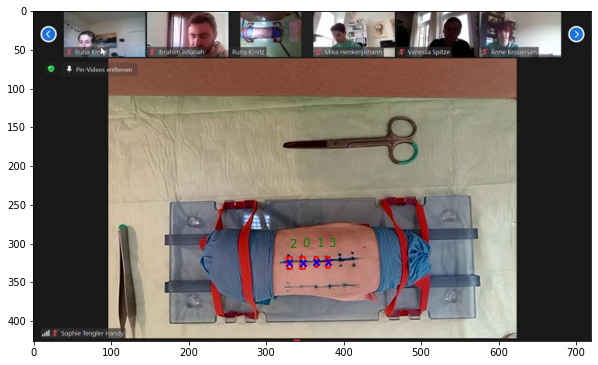

<Figure size 720x720 with 0 Axes>

In [30]:
dcv = pigleg_cv.DoComputerVision(
    mediafile_path,
    outputdir,
    test_first_seconds=test_first_seconds,
    is_microsurgery=is_microsurgery,
    force_tracker=force_tracker
)
dcv.run()

In [31]:
logger

<loguru.logger handlers=[]>

In [32]:
from loguru import logger
logger.debug("ahoj")

In [33]:
logger.warning("asdf")

In [34]:
# report_data = dcv.make_report()